In [1]:
N_RANDOM_RUNS = 10
USE_CACHE = True

In [2]:
import pandas as pd
import time
from tqdm import tqdm
import numpy as np
import random

from detector_radford import DetectorRadford
from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
from detector_dummy import DetectorDummy
detector_classes = [DetectorGuo, DetectorRadford, DetectorDetectGPT]



In [3]:
import torch
import numpy as np

In [4]:
test = pd.read_pickle("./dataset_test.pkl")
train = pd.read_pickle("./dataset_train.pkl")

In [5]:
documents = test["answer"]
gold_labels = test["author"] == "human_answers"


# documents = documents[0:50]
# gold_labels = gold_labels[0:50]

In [6]:
prediction_cache = {}
def prediction_cached(detector, documents):
    if detector.__class__.__name__ not in prediction_cache:
        prediction_cache[detector.__class__.__name__] = detector.predict_label(documents)
    return prediction_cache[detector.__class__.__name__]

In [7]:
results = []
if not USE_CACHE:
    for n in range(0, N_RANDOM_RUNS):
        for p_mask in ["single", 0.05, 0.1, 0.25,0.5,0.8]:
            random.seed(42+n) # not that of numpy!
            masked_documents = None
            if p_mask != "single":
                masked_documents = [" ".join([t if random.random() > p_mask else "<mask>" for t in document.split(" ")]) for document in documents]
            else:
                masked_documents = []
                for document in documents:
                    tokens = document.split(" ")
                    masked_documents.append(document.replace(random.sample(tokens,1)[0], "<mask>", 1))
                
            for detector_class in detector_classes:
                detector = detector_class()
                print(detector.__class__.__name__)
                predictions_original = prediction_cached(detector, documents) # enables batching

                experiments = {
                    "pad_token": lambda text: " ".join([t if t != "<mask>" else detector.get_pad_token() for t in text.split(" ")]), # all share the custom mask token
                    "space": lambda text: " ".join([t if t != "<mask>" else " " for t in text.split(" ")]),
                    "remove": lambda text: " ".join([t  for t in text.split(" ") if t != "<mask>"]),
                }
                for e, f in experiments.items():
                    print("       ", e, p_mask)
                    np.random.seed(42)
                    torch.manual_seed(42) 
                    predictions_masked = detector.predict_label([f(d) for d in masked_documents], deterministic=False) # enables batching

                    for p_o, p_m, gt  in zip(predictions_original, predictions_masked, gold_labels):
                        results.append((p_mask, detector.__class__.__name__, e, gt, p_o, p_m, n))

In [8]:
if not USE_CACHE:
    df = pd.DataFrame(results, columns=["p_replace", "Detector", "Experiment", "GT", "original", "masked", "run"])
    df.to_csv("./masking_test_results.csv", index=False)
df = pd.read_csv("./masking_test_results.csv")

In [9]:
df.loc[df["p_replace"] == "single", "p_replace"] = 0.00001 # to enable sorting
#df = df[df["p_replace"] != "single"]
df["p_replace"] = df["p_replace"].astype(float)
# df = df.reset_index(drop=True).sort_values(by="p_replace")
# df["p_replace"] = df["p_replace"].astype(str)
df["right_original"] = df["GT"] == df["original"]
df["right_masked"] = df["GT"] == df["masked"]

In [10]:
df

,p_replace,Detector,Experiment,GT,original,masked,run,right_original,right_masked
0,0.00001,DetectorGuo,pad_token,True,1,1,0,True,True
1,0.00001,DetectorGuo,pad_token,True,1,1,0,True,True
2,0.00001,DetectorGuo,pad_token,False,0,0,0,True,True
3,0.00001,DetectorGuo,pad_token,False,0,0,0,True,True
4,0.00001,DetectorGuo,pad_token,True,1,1,0,True,True
...,...,...,...,...,...,...,...,...,...
164695,0.80000,DetectorDetectGPT,remove,True,0,1,9,False,True
164696,0.80000,DetectorDetectGPT,remove,False,0,1,9,True,False
164697,0.80000,DetectorDetectGPT,remove,True,1,1,9,True,True
164698,0.80000,DetectorDetectGPT,remove,False,0,1,9,True,False


In [11]:
pd.DataFrame(df.groupby(["Detector", "Experiment", "p_replace", "run"])["masked"].mean())

masked
Detector          Experiment p_replace run          
DetectorDetectGPT pad_token  0.00001   0    0.318033
                                       1    0.324590
                                       2    0.321311
                                       3    0.350820
                                       4    0.318033
...                                              ...
DetectorRadford   space      0.80000   5    0.183607
                                       6    0.190164
                                       7    0.170492
                                       8    0.163934
                                       9    0.177049

[540 rows x 1 columns]

In [12]:
original = df[df["p_replace"]== 0.05].copy()
original["masked"] = original["original"]
original["p_replace"] = 0

In [13]:
dfa = pd.concat([df,original])
dfa = dfa.rename(columns={'masked': 'prediction',})

In [14]:
import matplotlib.pylab as plt
import seaborn as sns


In [15]:
dfa["GT"].mean()

0.49836065573770494

In [16]:
# f, axes = plt.subplots(1,3, sharey=True, sharex=True, figsize=(15,5))
# for ax, (experiment, group) in zip(axes, dfa.groupby([ "Detector"])):
#     sns.violinplot(data=group, x="Experiment", y="p_replace", hue="prediction", density_norm="count",common_norm=True, inner="stick",
#                 split=True, fill=False,ax=ax
#                 )
#     ax.set_title(experiment[0])
# plt.show()

In [17]:
# f, axes = plt.subplots(1,3, sharey=True, sharex=True, figsize=(15,5))
# for ax, (experiment, group) in zip(axes, dfa.groupby([ "Detector"])):
#     sns.violinplot(data=group, x="Experiment", y="p_replace", hue="prediction", density_norm="count",common_norm=True, inner="stick",
#                 split=True, fill=False,ax=ax
#                 )
#     ax.set_title(experiment[0])
# plt.show()

In [18]:
dfa

,p_replace,Detector,Experiment,GT,original,prediction,run,right_original,right_masked
0,0.00001,DetectorGuo,pad_token,True,1,1,0,True,True
1,0.00001,DetectorGuo,pad_token,True,1,1,0,True,True
2,0.00001,DetectorGuo,pad_token,False,0,0,0,True,True
3,0.00001,DetectorGuo,pad_token,False,0,0,0,True,True
4,0.00001,DetectorGuo,pad_token,True,1,1,0,True,True
...,...,...,...,...,...,...,...,...,...
153715,0.00000,DetectorDetectGPT,remove,True,0,0,9,False,True
153716,0.00000,DetectorDetectGPT,remove,False,0,0,9,True,True
153717,0.00000,DetectorDetectGPT,remove,True,1,1,9,True,False
153718,0.00000,DetectorDetectGPT,remove,False,0,0,9,True,True


In [19]:
import matplotlib.gridspec as gridspec


In [20]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",
    'text.usetex': True,
    'pgf.rcfonts': False,
})

C:\Users\loris\AppData\Local\Temp\ipykernel_28736\2699638934.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  first_ax.set_yticklabels(labels)


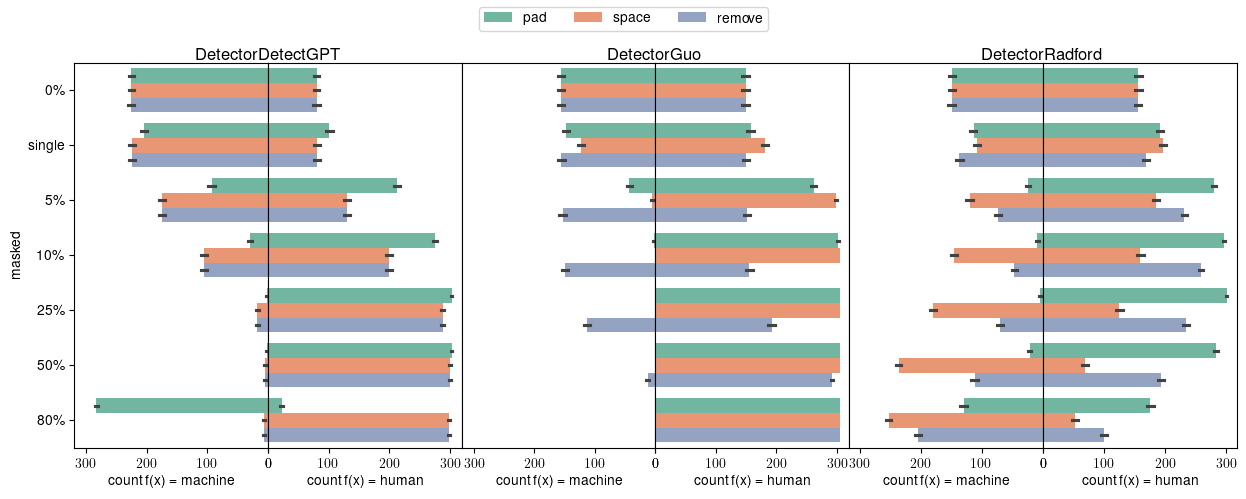

In [21]:
# https://stackoverflow.com/questions/70088196/two-sided-grouped-barplots-with-python-seaborn
dfff = pd.DataFrame(dfa.reset_index(drop=True))
dfff.loc[dfff["Experiment"] == "pad_token", "Experiment"] = "pad"
#dfff['Experiment'] = pd.Categorical(dfff['Experiment'])  # make hue column categorical, forcing a fixed order
dfff = dfff[["prediction", "run", "p_replace", "Experiment", "Detector"]]
sns.set_palette(sns.color_palette("Set2"))
fig = plt.figure(figsize=(15, 5))
outer = gridspec.GridSpec(1,3, wspace=0.0, hspace=0.2)
first_ax = None
for o, (detector, group) in zip(outer, dfff.groupby(["Detector", ])):
    
   # group = group.drop("run", axis=1)
   # group.loc[group["prediction"] == 0, "prediction"] = -1
   # display(group)
   # display(group)
    ax = plt.Subplot(fig, o)
    ax.axis('off')
    ax.text(0.5,1.01, detector[0],fontsize=12, weight='bold', ha='center')
    fig.add_subplot(ax)
    (i, ii) = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=o, wspace=0.0, hspace=0.0)
    ax1 = plt.Subplot(fig, i)
    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, ii)
    fig.add_subplot(ax2)
    # draw adult subplot at the right
    sns.barplot(data=group, x='prediction', y="p_replace", hue='Experiment',estimator=lambda x : np.count_nonzero(x == 1)/N_RANDOM_RUNS,errorbar="ci",
                orient='horizontal', dodge=True, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('count f(x) = human')
    ax2.tick_params(axis='y', labelright=False,  right=False, labelleft=False, left=False)
    #ax2.set_title('  '+'human', loc='left')
    ax2.legend_.remove() 

    sns.barplot(data=group, x='prediction',y="p_replace", hue='Experiment',estimator=lambda x : np.count_nonzero(x == 0)/N_RANDOM_RUNS,errorbar="ci",
                orient='horizontal', dodge=True, ax=ax1)

    # optionally use the same scale left and right
    xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
    ax1.set_xlim(xmax=xmax)
    ax2.set_xlim(xmax=xmax)
    if first_ax is None:
        first_ax = ax1
    
    ax1.invert_xaxis() 
    ax1.tick_params(axis='y', labelright=False, right=False, labelleft=False, left=False)
    ax1.set_ylabel('')
    ax1.set_xlabel('count f(x) = machine')
    ax1.set_xlim(None, 0)
    ax1.legend_.remove()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, )


first_ax.tick_params(axis='y', labelright=False, right=False, labelleft=True, left=True)
first_ax.set_ylabel("masked")
labels = ["{:.0f}\%".format(float(item.get_text())*100) for item in first_ax.get_yticklabels()]
labels[1] = 'original'
labels[1] = 'single'
first_ax.set_yticklabels(labels)
plt.savefig('./figures/masking.pgf')
plt.show()    

# Change in Accuracy


DetectorDetectGPT


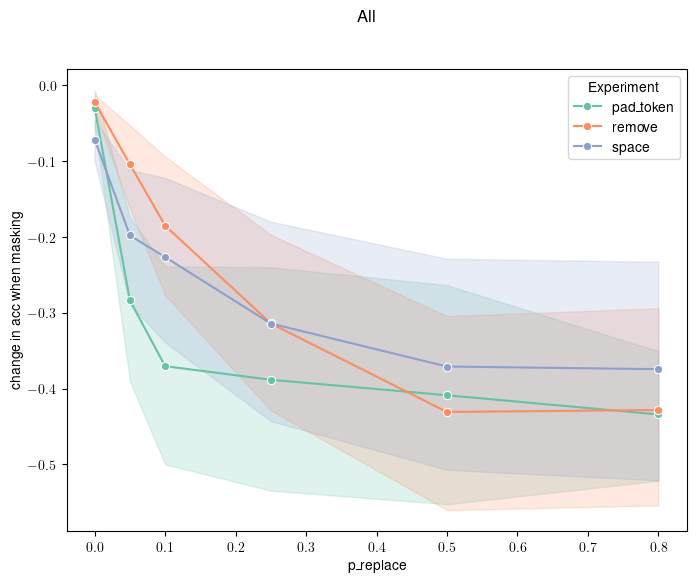

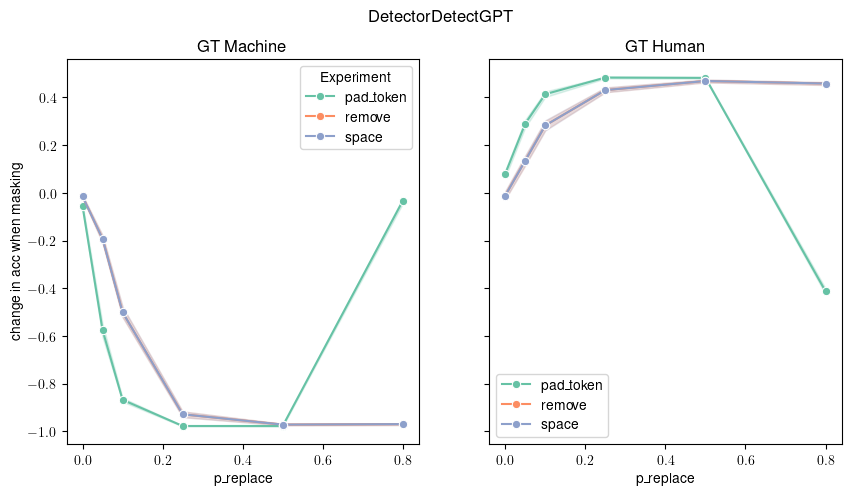

DetectorGuo


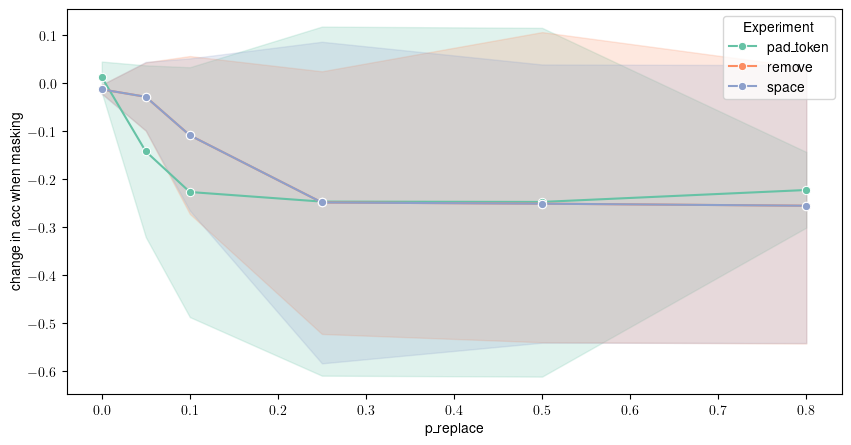

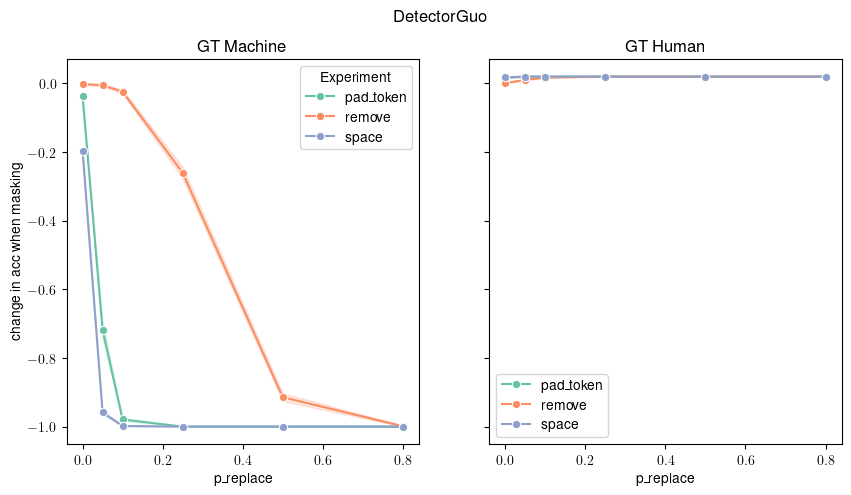

DetectorRadford


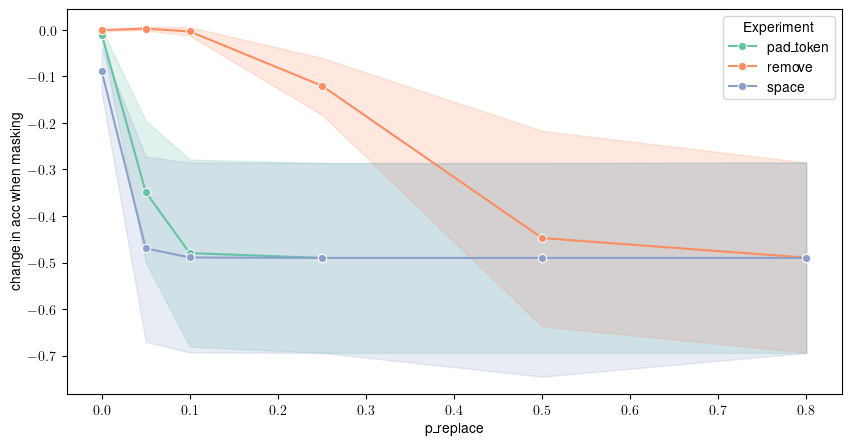

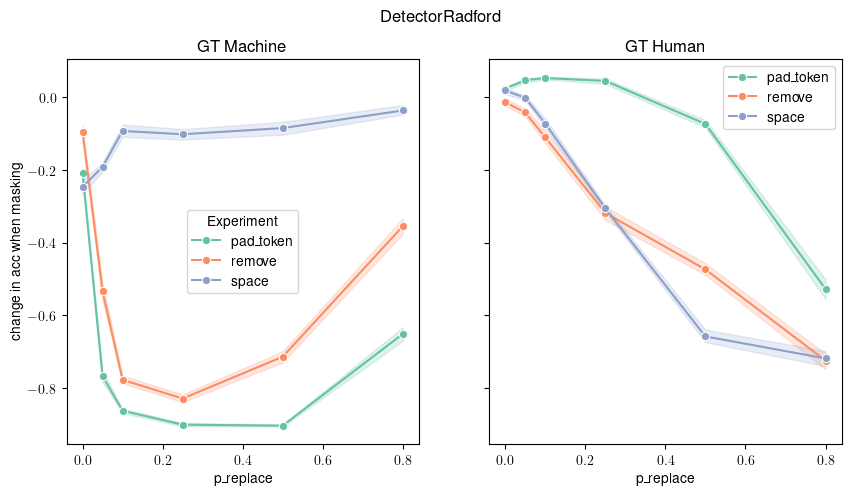

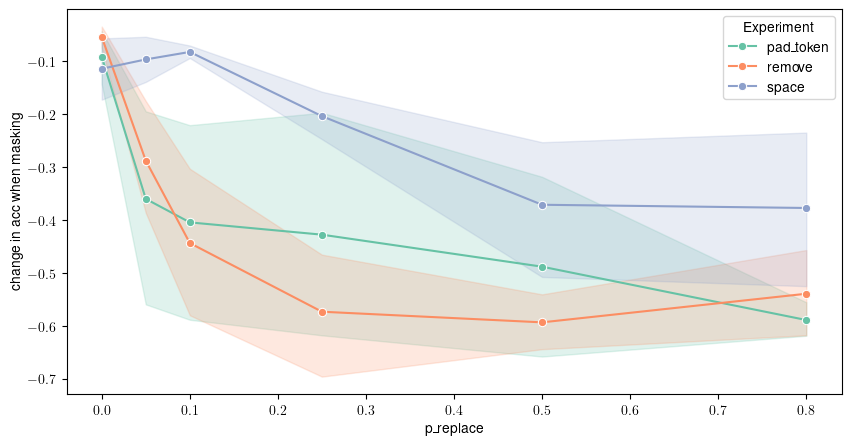

In [22]:
change_in_accuracy = df.groupby(["Detector", "Experiment", "p_replace", "run", "GT"]).apply(lambda g: g["right_masked"].mean() - g["right_original"].mean())
change_in_accuracy
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle("All")
sns.lineplot(data=pd.DataFrame(change_in_accuracy, columns=["change in acc when masking"]), x="p_replace", y="change in acc when masking", hue="Experiment", ax=ax, marker="o")
for detector, group in change_in_accuracy.groupby("Detector"):
    f, (ax_machine, ax_human) = plt.subplots(1,2, sharey=True, figsize=(10,5))
    plt.suptitle(detector)
    #     ax.plot(row.index.get_level_values(2), row.values, label=experiment)
    
    group = pd.DataFrame(group, columns=["change in acc when masking"]).reset_index()
    
    #     ax.plot(row.index.get_level_values(2), row.values, label=experiment)
    sns.lineplot(data=group[~group["GT"]], x="p_replace", y="change in acc when masking", hue="Experiment", ax=ax_machine, marker="o")
    sns.lineplot(data=group[group["GT"]], x="p_replace", y="change in acc when masking", hue="Experiment", ax=ax_human, marker="o")
    ax_machine.set_title("GT Machine")
    ax_human.set_title("GT Human")
    print(detector)
    plt.legend()
    plt.show()
    f, ax = plt.subplots(sharey=True, figsize=(10,5))
    sns.lineplot(data=group, x="p_replace", y="change in acc when masking", hue="Experiment", ax=ax, marker="o")
    # ax.plot(g.index.get_level_values(0), g.values, label=str(n) + " " + str(name))
        #ax.set_xticklabels([item.get_text().split(",")[0][1:] for item in ax.get_xticklabels()])

# Did the label flip?

In [23]:
label_flip = df.groupby(["Detector", "Experiment", "p_replace", "run", "GT"]).apply(lambda g: (g["original"] != g["masked"]).mean())
label_flip

Detector           Experiment  p_replace  run  GT   
DetectorDetectGPT  pad_token   0.00001    0    False    0.058824
                                               True     0.328947
                                          1    False    0.098039
                                               True     0.355263
                                          2    False    0.084967
                                                          ...   
DetectorRadford    space       0.80000    7    True     0.743421
                                          8    False    0.196078
                                               True     0.750000
                                          9    False    0.228758
                                               True     0.743421
Length: 1080, dtype: float64

In [24]:
label_flip

Detector           Experiment  p_replace  run  GT   
DetectorDetectGPT  pad_token   0.00001    0    False    0.058824
                                               True     0.328947
                                          1    False    0.098039
                                               True     0.355263
                                          2    False    0.084967
                                                          ...   
DetectorRadford    space       0.80000    7    True     0.743421
                                          8    False    0.196078
                                               True     0.750000
                                          9    False    0.228758
                                               True     0.743421
Length: 1080, dtype: float64

<Axes: xlabel='p_replace', ylabel='proportion label flip when x% removed'>

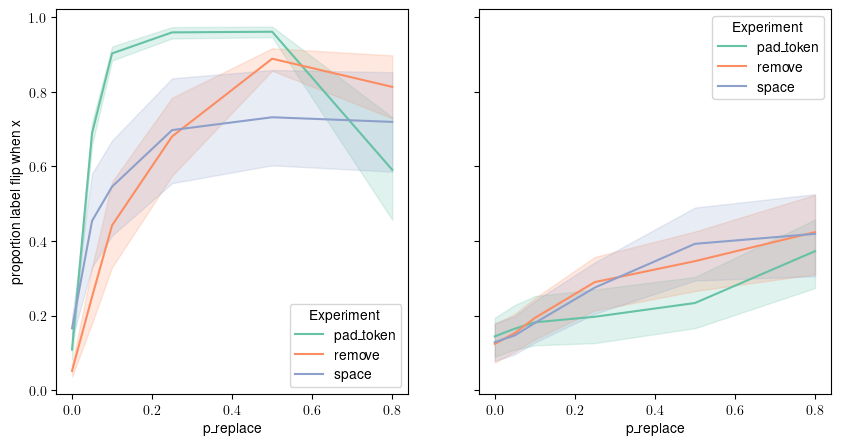

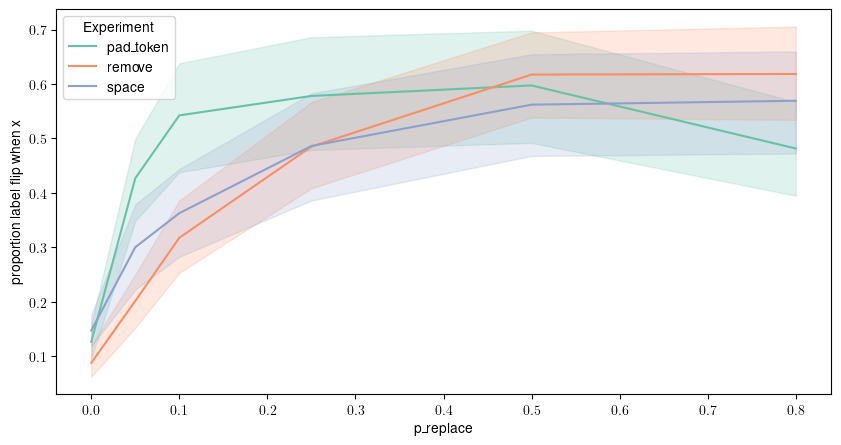

In [25]:
f, (ax_machine, ax_human) = plt.subplots(1,2, sharey=True, figsize=(10,5))
group = pd.DataFrame(label_flip, columns=["proportion label flip when x% removed"]).reset_index()
    
    #     ax.plot(row.index.get_level_values(2), row.values, label=experiment)
sns.lineplot(data=group[~group["GT"]], x="p_replace", y="proportion label flip when x% removed", hue="Experiment", ax=ax_machine)
sns.lineplot(data=group[group["GT"]], x="p_replace", y="proportion label flip when x% removed", hue="Experiment", ax=ax_human)

f, ax = plt.subplots(sharey=True, figsize=(10,5))
group = pd.DataFrame(label_flip, columns=["proportion label flip when x% removed"]).reset_index()
    
    #     ax.plot(row.index.get_level_values(2), row.values, label=experiment)
sns.lineplot(data=group, x="p_replace", y="proportion label flip when x% removed", hue="Experiment", ax=ax)


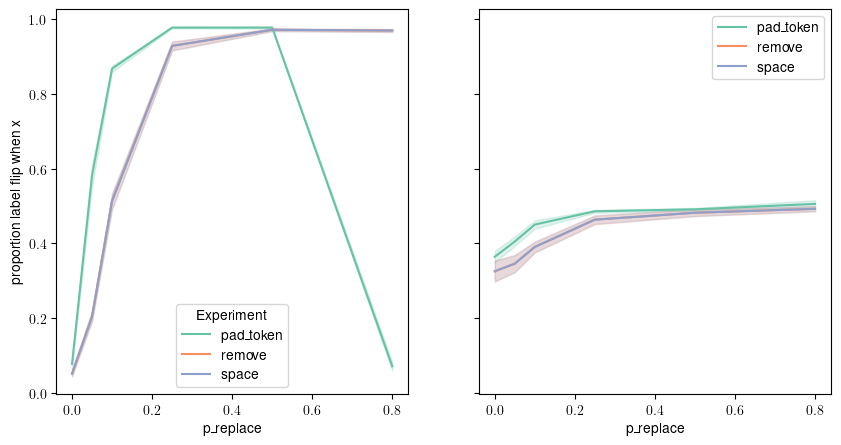

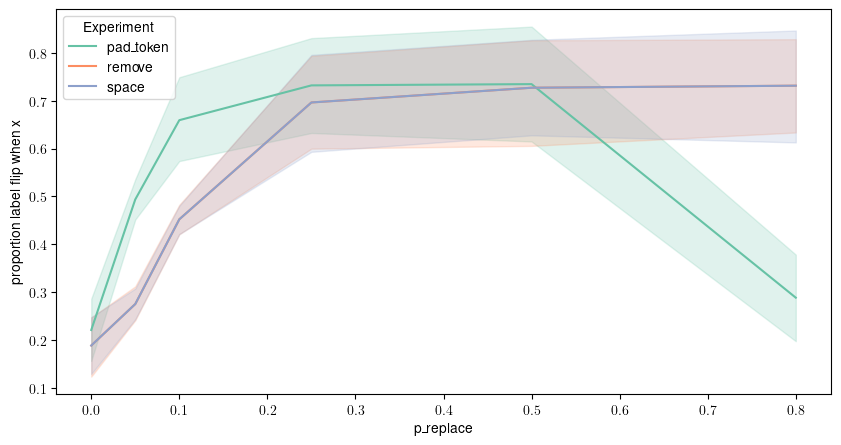

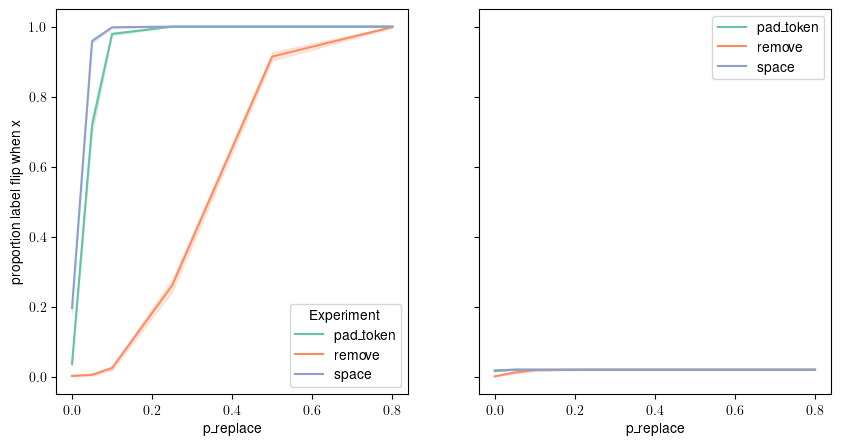

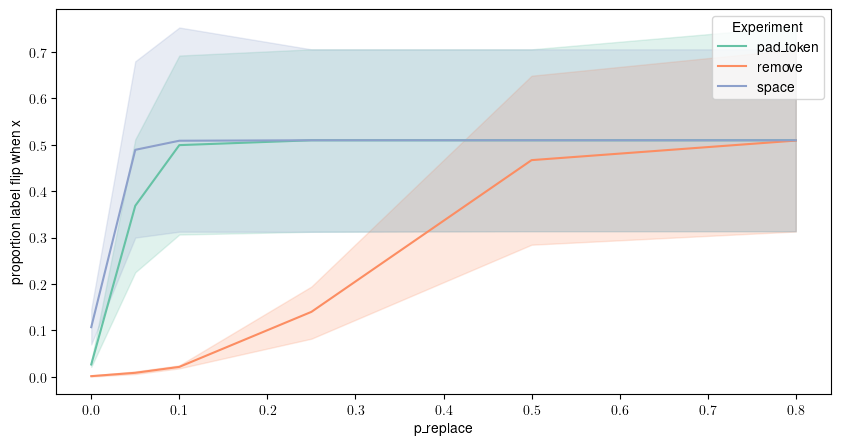

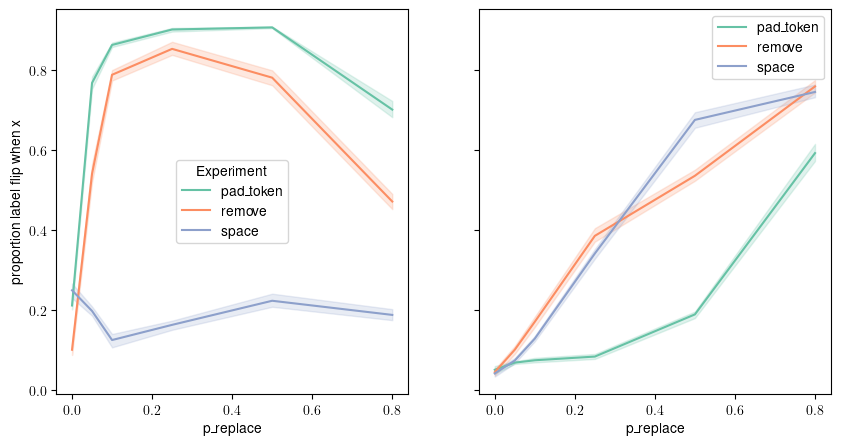

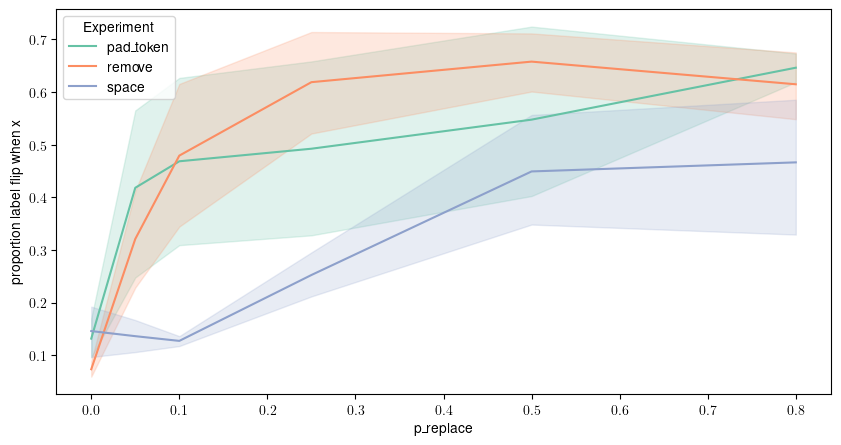

In [26]:
for detector, group in label_flip.groupby("Detector"):
    f, (ax_machine, ax_human) = plt.subplots(1,2, sharey=True, figsize=(10,5))

    # for experiment, row in group.groupby("Experiment"):
    group = pd.DataFrame(group, columns=["proportion label flip when x% removed"]).reset_index()
    
    #     ax.plot(row.index.get_level_values(2), row.values, label=experiment)
    sns.lineplot(data=group[~group["GT"]], x="p_replace", y="proportion label flip when x% removed", hue="Experiment", ax=ax_machine)
    sns.lineplot(data=group[group["GT"]], x="p_replace", y="proportion label flip when x% removed", hue="Experiment", ax=ax_human)

    plt.legend()
    plt.show()

    f, ax = plt.subplots(sharey=True, figsize=(10,5))
    sns.lineplot(data=group, x="p_replace", y="proportion label flip when x% removed", hue="Experiment", ax=ax)
    # ax.plot(g.index.get_level_values(0), g.values, label=str(n) + " " + str(name))
        #ax.set_xticklabels([item.get_text().split(",")[0][1:] for item in ax.get_xticklabels()])

## Conclusion (Old)
No masking strategy works best across all detectors and percentages masked. Note that none of these detectors were trained to support partial data. 
The masking strategy "pad_token" is chosen for both LIME and SHAP for the following reasons:
- In SHAP, this is the method demonstrated in the documentation for transformer based models: [Doc 1](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html) [Doc 2](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)
- For LIME, the default is either removing words or replacing them with a (user-defined) masking string. For the detector of Guo et al., "multiple space characters" appear to be an important feature utilized for detection (see discussion on H3 dataset). Using a masking string is therefore preferred over the removal of tokens or the addition of spaces here. LIME would otherwise be unable to highlight that feature as spaces (the sep token) are always collapsed in the default implementation.
- In the unprocessed dataset, human and ChatGPT-generated answers differed significantly in their average lengths. The last subplot here suggests that the detector from Guo et al. might utilize this fact (removing tokens does not flip the label for GT=human). Masking via the attention mask retains the length of the text. LIME would also collapse spaces.

To summarize: The best masking strategy differs by detector and percentage of words masked. Masking via the pad_token is selected as it does not lead LIME to ignore the feature "multiple spaces", which would make its explanations unfaithful by default.